In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Online Retail Data.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


**Finding duplicate items - Data Preprocessing**

In [ ]:
print(f'Duplicate Items in Dataset:{data.duplicated().sum()}')

Duplicate Items in Dataset:5268


In [ ]:
# Removing duplicate items
data = data.drop_duplicates()

In [ ]:
#Checking for missing values
print(f'Count of Missing Values: {data.isnull().sum()}')

Count of Missing Values: InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64


In [ ]:
#Creates a list of unique invoice No. with Null Customer ID - new invoice list

invoice_list = data[data.CustomerID.isnull()]['InvoiceNo'].tolist()
print(invoice_list[:10])

[536414, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544, 536544]


In [ ]:
len(data[data.InvoiceNo.isin(invoice_list)])

135037

**Creating Training Data**

In [ ]:
# Removing Inconsistent Records

print("The number of records with Quantity Negative and Prices 0 or Vice versa : ",data[(data.Quantity<=0) & (data.UnitPrice<=0)].shape[0])

#Checking if Negative quantities are cancelled items
print("Cancelled Items have Invoice Starting with : ",data.loc[(data.Quantity<0) & ~(data.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

#Checking for Records with Negative Unit Price
print("The number of transactions with Negative Unit Price : ",data[(data.UnitPrice<0)].shape[0])

#Checking for Records with Unit Price 0
print("The number of transactions with Unit Price 0 : ",data[(data.UnitPrice==0)  & ~(data.CustomerID.isnull())].shape[0])

The number of records with Quantity Negative and Prices 0 or Vice versa :  1336
Cancelled Items have Invoice Starting with :  ['C']
The number of transactions with Negative Unit Price :  2
The number of transactions with Unit Price 0 :  40


In [ ]:
#Removing records with Null Customer ID
data = data[data.CustomerID.notnull()]

#Removing Transactions with Unit Price 0
data = data[data.UnitPrice>0]

In [ ]:
rfm_train = data.copy()

In [ ]:
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [ ]:
print(f'Count of Missing values:{rfm_train.isnull().sum()}')

Count of Missing values:InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [ ]:
# REMOVE transactions with Cancelled Items.
placed = rfm_train[~rfm_train.InvoiceNo.str.contains('C',na=False)]

In [ ]:
placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice

/tmp/ipython-input-140923902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed['TotalCost'] = rfm_train.Quantity * rfm_train.UnitPrice


**Exploratory Data Analysis**

In [ ]:
# To Find The Time Period of Transactions
print(f'Oldest date is:{placed.InvoiceDate.min()}\n')
print(f'Latest date is:{placed.InvoiceDate.max()}\n')

Oldest date is:2010-12-01 08:26:00

Latest date is:2011-12-09 12:50:00



In [ ]:
#Order Density in Different Countries
placed.Country.value_counts(normalize=True).head(12).mul(100).round(1).astype(str)+'%'

,proportion
Country,
United Kingdom,88.9%
Germany,2.3%
France,2.1%
EIRE,1.8%
Spain,0.6%
Netherlands,0.6%
Belgium,0.5%
Switzerland,0.5%
Portugal,0.4%


/tmp/ipython-input-3614362650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')


<Axes: xlabel='InvoiceDate'>

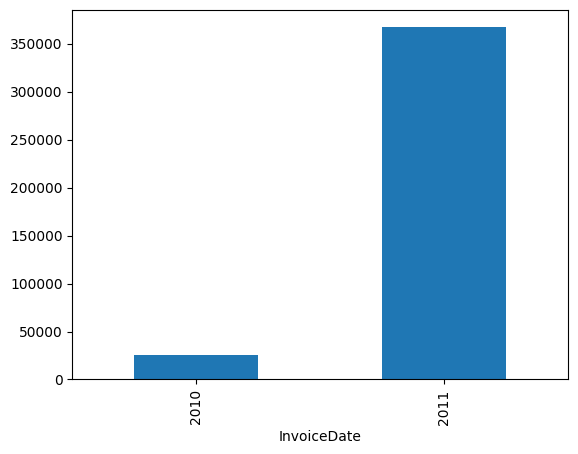

In [ ]:
placed['InvoiceDate'] = pd.to_datetime(placed['InvoiceDate'], errors='coerce')
placed.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar')

<Axes: xlabel='InvoiceDate'>

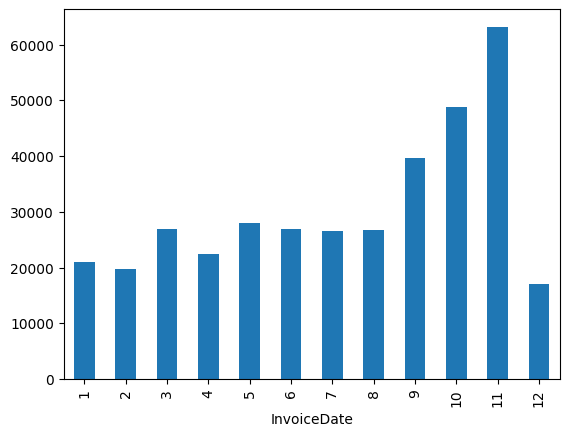

In [ ]:
placed[placed.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar')

##Monthly Gross

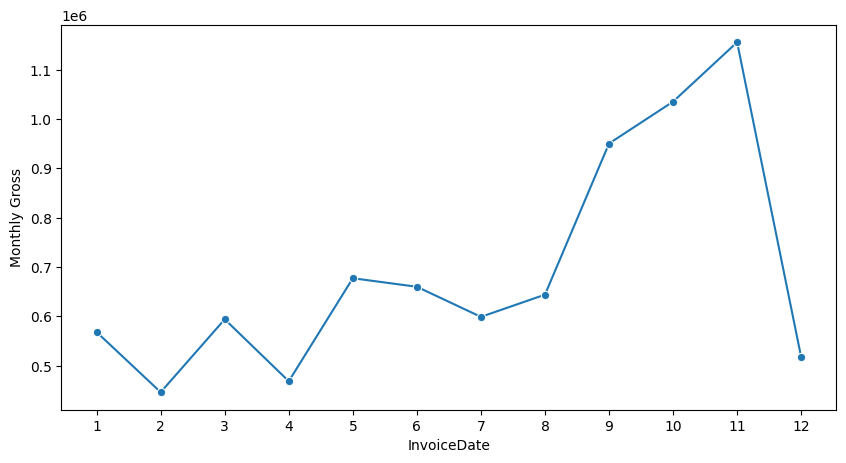

In [ ]:
monthly_gross = placed[placed.InvoiceDate.dt.year==2011].groupby(placed.InvoiceDate.dt.month).TotalCost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index,marker='o')
plt.xticks(range(1,13))
plt.ylabel('Monthly Gross')
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


<Axes: ylabel='UnitPrice'>

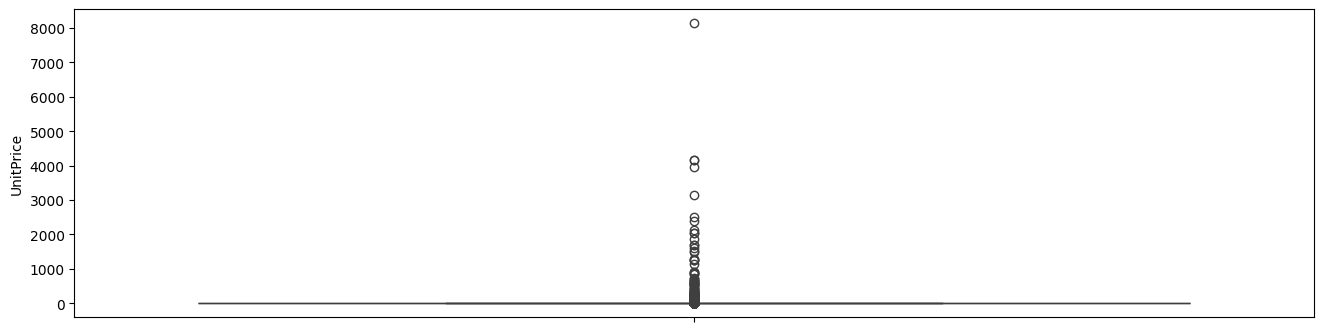

In [ ]:
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice',data = placed,orient='h')

##Top Selling Products

In [ ]:
placed.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


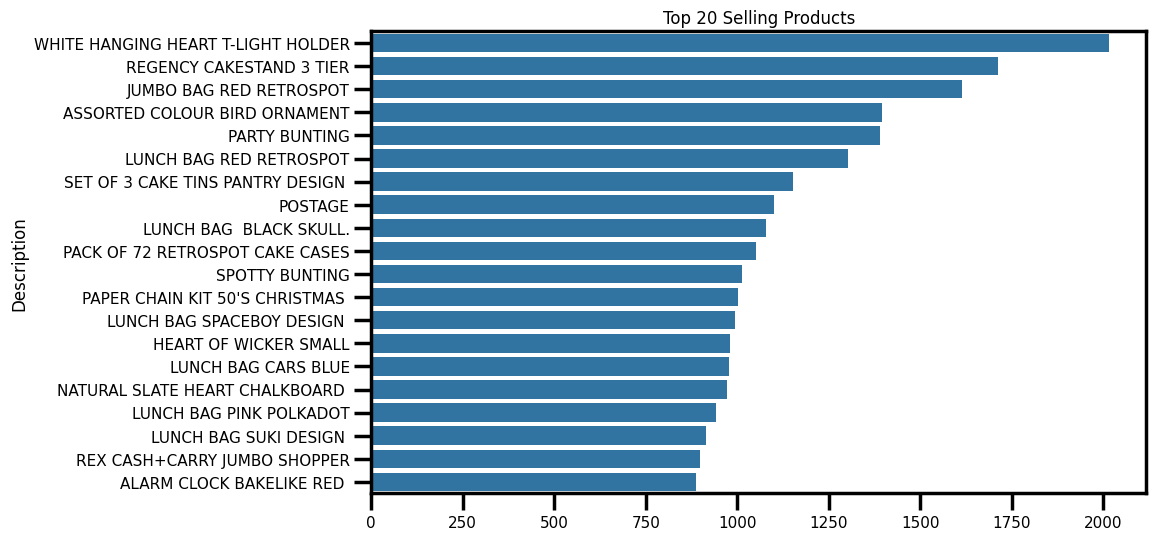

In [ ]:
top_products = placed['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("poster",font_scale=0.5)
sns.barplot(y=top_products.index,x=top_products.values)
plt.title('Top 20 Selling Products')
plt.show()

##Cohort Analysis

In [ ]:
# Create a copy of rfm_train dataframe for cohort analysis
cohort = rfm_train.copy()

#cohort['InvoiceDate'] = pd.to_datetime(cohort['InvoiceDate'], errors='coerce')

# Define a function that will parse the date

#import datetime as dt

def get_month(x):
    return dt.datetime(x.year,x.month,1)

# Create InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month)

# Group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth']
print(grouping)
# Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')


def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month


# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1
#cohort.tail(20)


##Retention Rate

In [ ]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])

#No. of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes,axis=0)*100

print(cohort_counts)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01  948.00 362.00 317.00 367.00 341.00 376.00 360.00 336.00 336.00   
2011-01-01  421.00 101.00 119.00 102.00 138.00 126.00 110.00 108.00 131.00   
2011-02-01  380.00  94.00  73.00 106.00 102.00  94.00  97.00 107.00  98.00   
2011-03-01  440.00  84.00 112.00  96.00 102.00  78.00 116.00 105.00 127.00   
2011-04-01  299.00  68.00  66.00  63.00  62.00  71.00  69.00  78.00  25.00   
2011-05-01  279.00  66.00  48.00  48.00  60.00  68.00  74.00  29.00    NaN   
2011-06-01  235.00  49.00  44.00  64.00  58.00  79.00  24.00    NaN    NaN   
2011-07-01  191.00  40.00  39.00  44.00  52.00  22.00    NaN    NaN    NaN   
2011-08-01  167.00  42.00  42.00  42.00  23.00    NaN    NaN    NaN    NaN   
2011-09-01  298.00  89.00  97.00  36.00    NaN    NaN    NaN    NaN    NaN   
2011-10-01  352.00  93.00  46.00    NaN    NaN    NaN    NaN    

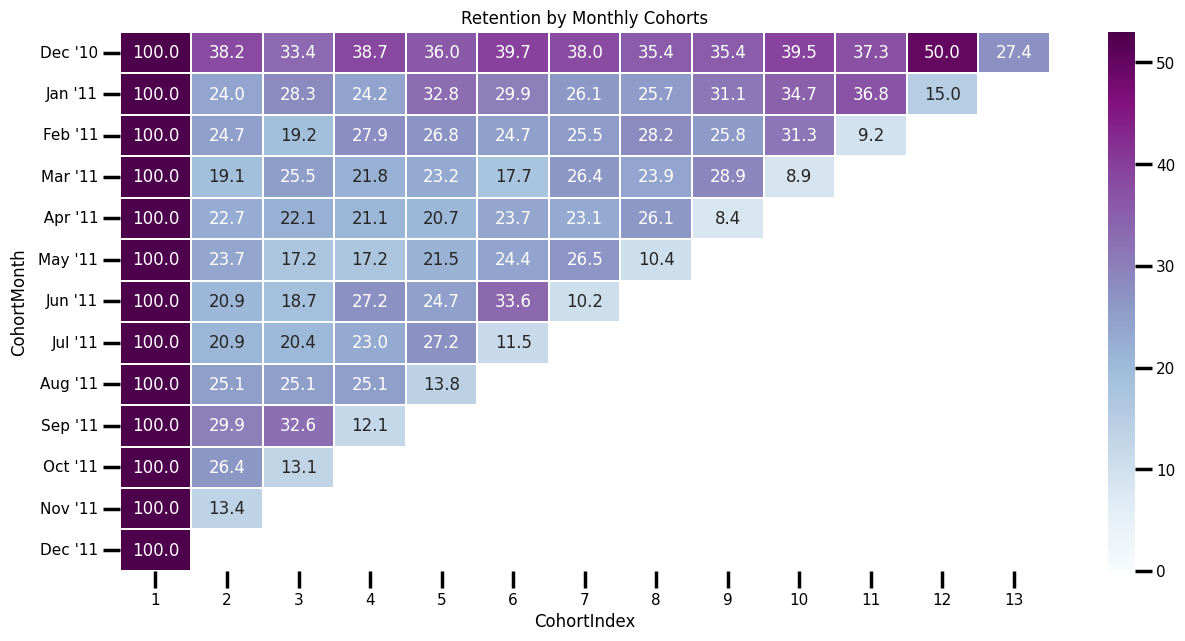

In [ ]:
monthlist=["Dec '10","Jan '11","Feb '11","Mar '11","  Apr '11","May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11","Oct '11", "Nov '11", "Dec '11"]

plt.figure(figsize=(15,7))

plt.title('Retention by Monthly Cohorts')

sns.heatmap(retention,annot=True,cmap='BuPu',vmin=0.0,vmax = list(retention.max().sort_values(ascending = False))[1]+3,linewidth=0.3,fmt = '.1f',yticklabels=monthlist)

plt.show()

## Avg Price for each Cohort

In [ ]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['UnitPrice'].mean()
cohort_data = cohort_data.reset_index()
average_price = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

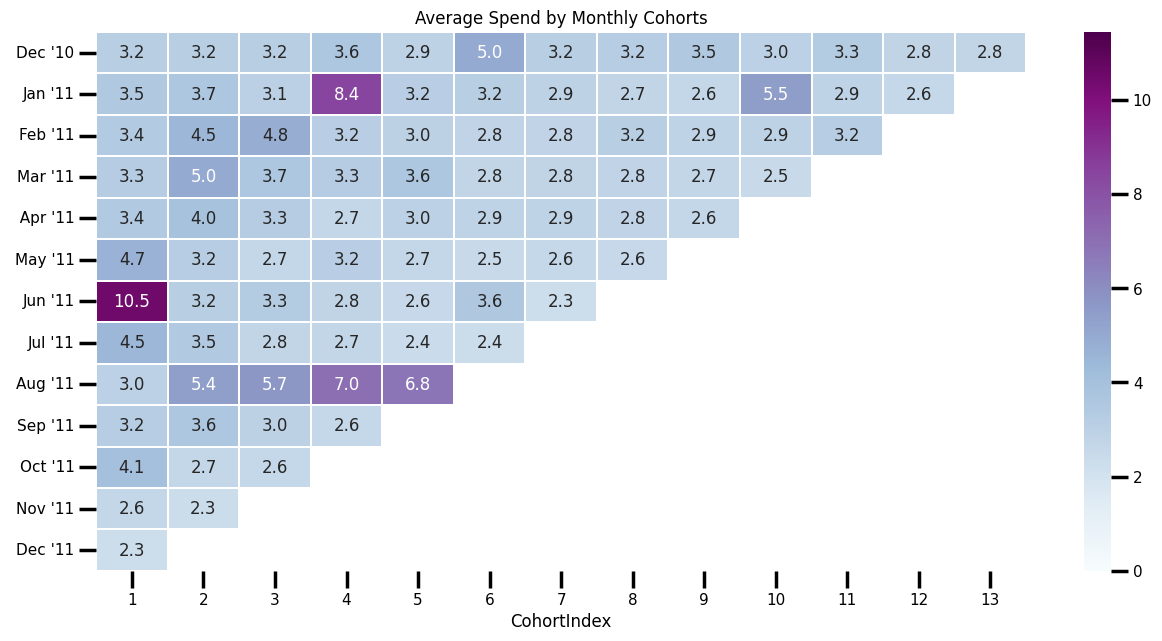

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(average_price,annot=True,vmin=0.0,cmap='BuPu',vmax=list(average_price.max().sort_values(ascending=False))[1]+3,fmt='.1f',linewidths=0.3,yticklabels=monthlist)
plt.show()

## Average Quantity per Cohort

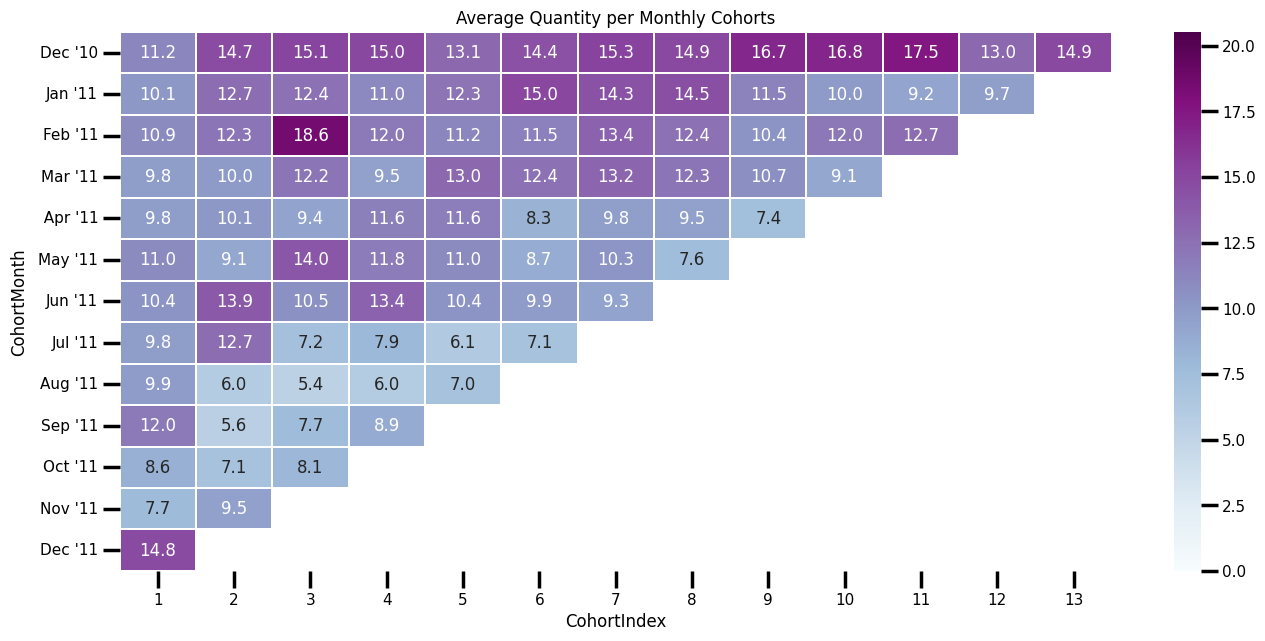

In [ ]:
grouping = cohort.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')

plt.figure(figsize=(16,7))
plt.title('Average Quantity per Monthly Cohorts')
sns.heatmap(average_quantity,vmin=0.0,vmax=list(average_quantity.max().sort_values(ascending=False))[1]+3,cmap='BuPu',linewidth=0.3,fmt='.1f',yticklabels=monthlist,annot=True)
plt.show()

## RFM Analysis

In [ ]:
## Lastest date in the Order History
rfm_train['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
current_date = dt.date(2011,12,10)

In [ ]:
rfm_train['InvoiceDate'] = pd.to_datetime(rfm_train['InvoiceDate'], errors='coerce')
rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date
print(rfm_train['Purchase_Date'])

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541904    2011-12-09
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
Name: Purchase_Date, Length: 401564, dtype: object


In [ ]:
#Creating Separate Column for recency
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [ ]:
recency = recency.assign(Current_Date=current_date)
recency['Recency'] = recency.Purchase_Date.apply(lambda x:(current_date-x).days)
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-10,326
1,12347,2011-12-07,2011-12-10,3
2,12348,2011-09-25,2011-12-10,76
3,12349,2011-11-21,2011-12-10,19
4,12350,2011-02-02,2011-12-10,311


In [ ]:
## Drop Date Columns which is not useful anymore.
recency.drop(['Purchase_Date','Current_Date'],axis=1,inplace=True)
recency.head()

,CustomerID,Recency
0,12346,326
1,12347,3
2,12348,76
3,12349,19
4,12350,311


In [ ]:
# Create Seperate Column for Frequency


frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [ ]:
# Create seperate Column for Monetary

rfm_train['TotalCost'] = rfm_train.Quantity*rfm_train.UnitPrice
monetary = rfm_train.groupby('CustomerID').TotalCost.sum().reset_index().rename(columns={'TotalCost':'Monetary'})
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


## Combining R_F_M together

In [ ]:
combine = recency.merge(frequency,on='CustomerID')
rfm_table = combine.merge(monetary,on='CustomerID')
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


Customer with ID = 12346 has recency:3 days, frequency:7 and monetary: 4310.00

### QQ-Plot

In [ ]:
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox


def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1939259358.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


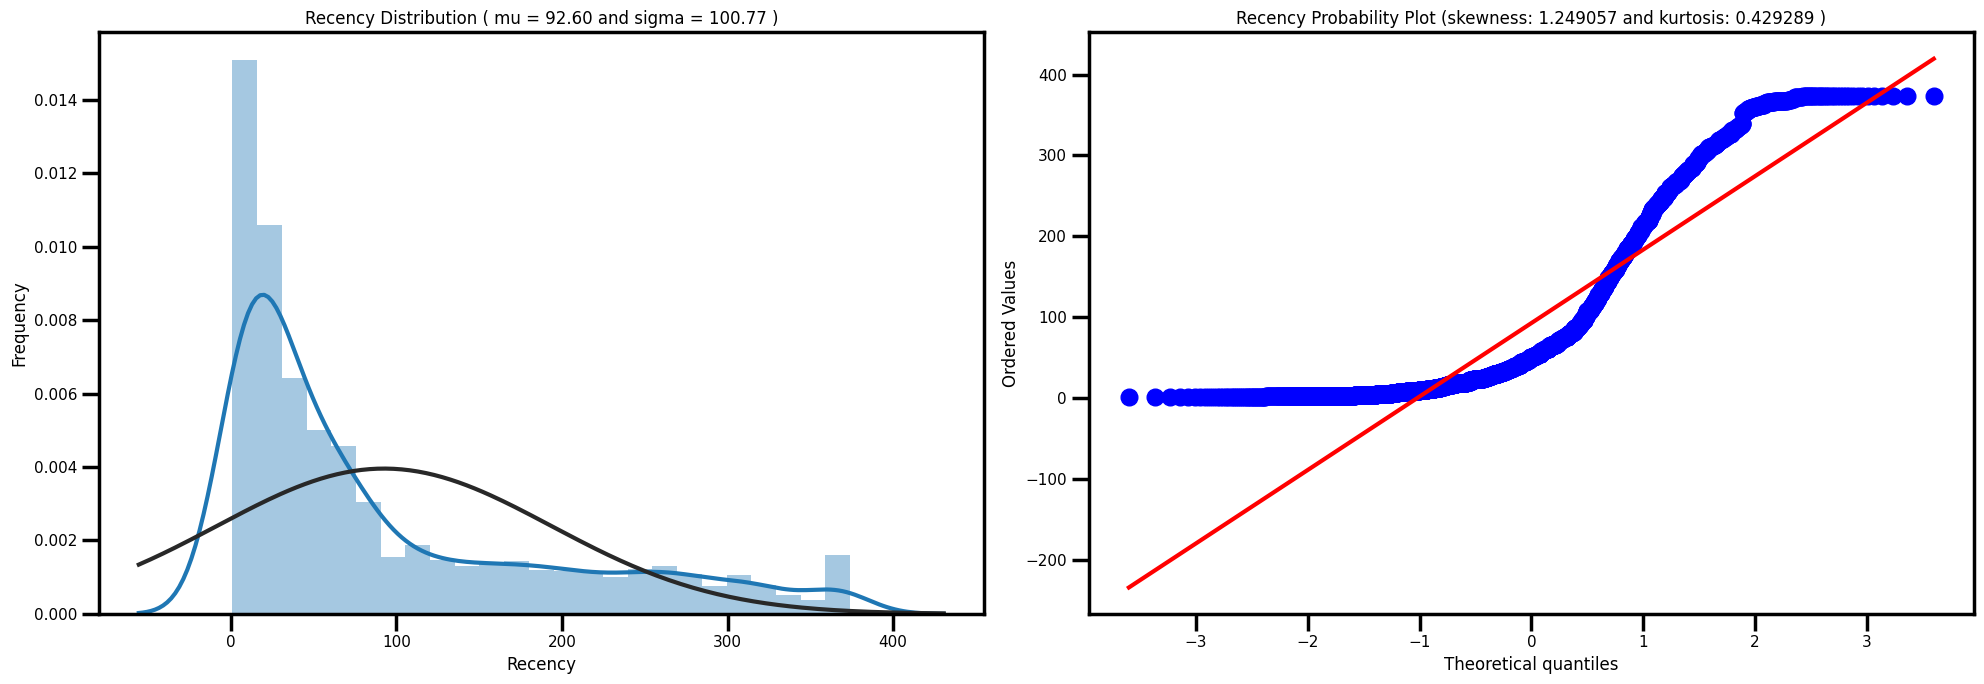

In [ ]:
# Recency
QQ_plot(rfm_table.Recency,'Recency')

/tmp/ipython-input-1939259358.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


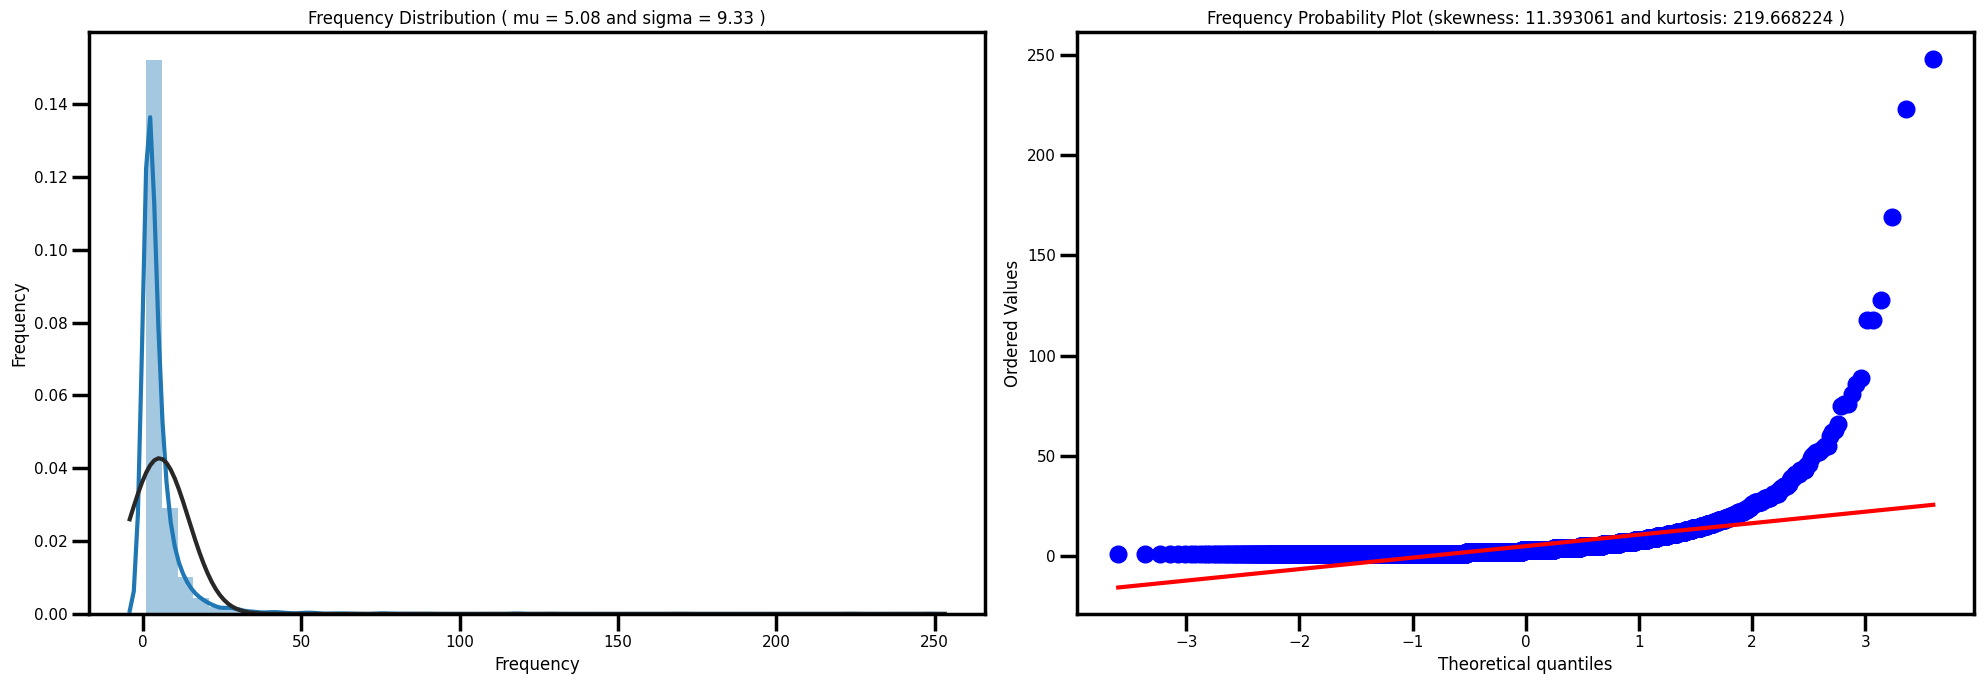

In [ ]:
#Frequency
QQ_plot(rfm_table.Frequency,'Frequency')

/tmp/ipython-input-1939259358.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


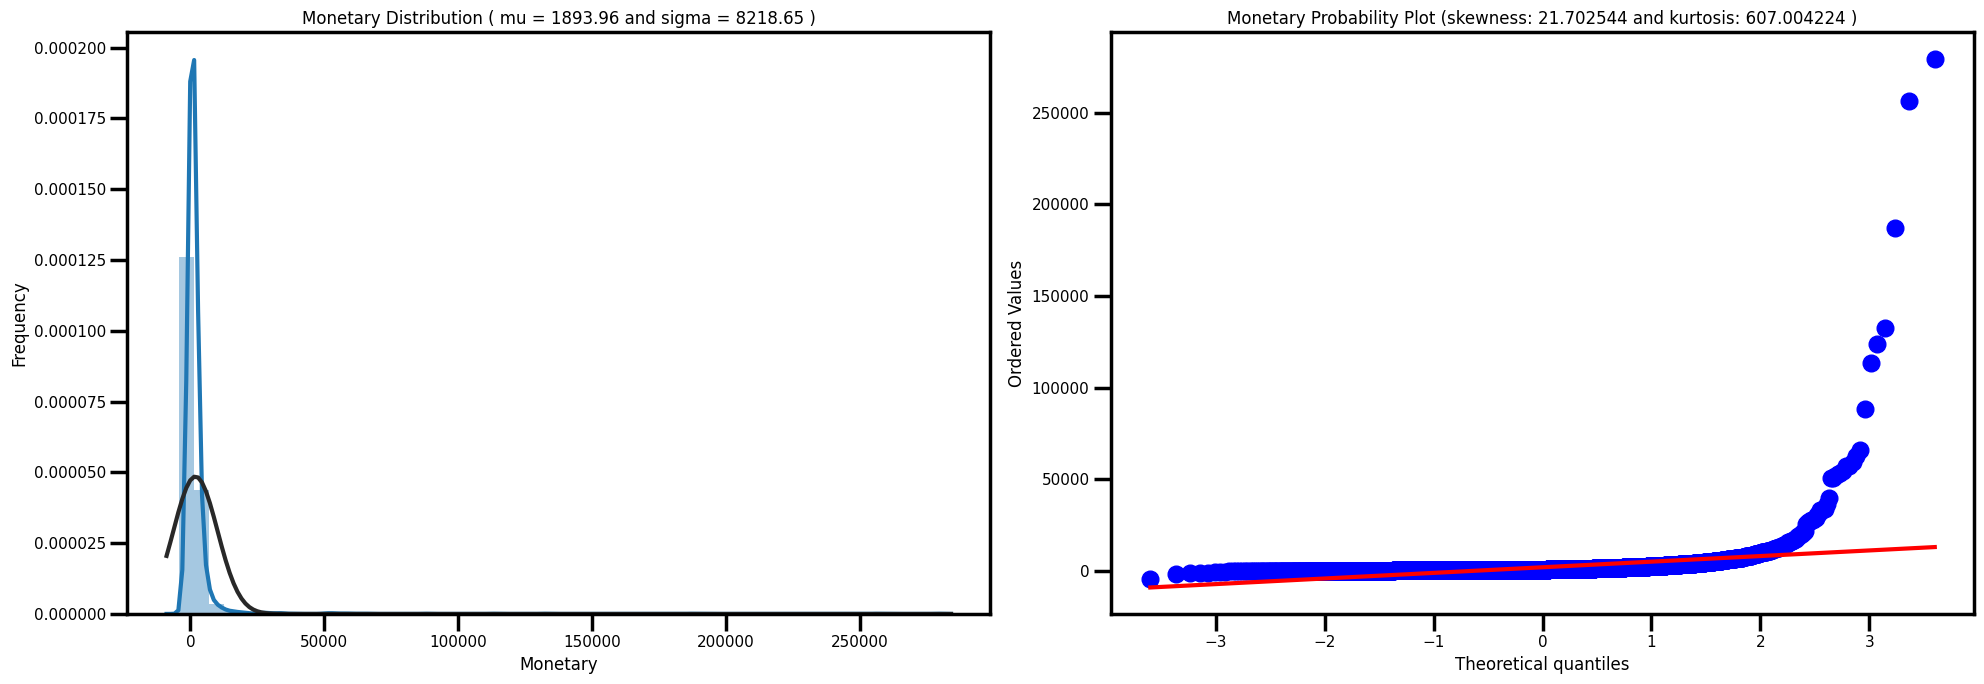

In [ ]:
#Monetary
QQ_plot(rfm_table.Monetary,'Monetary')

## Segmentation of Customers using Quantiles

In [ ]:
quantile = rfm_table.quantile(q=[0.25,0.50,0.75])
print(quantile)

      Recency  Frequency  Monetary
0.25    17.00       1.00    291.94
0.50    51.00       3.00    644.24
0.75   144.00       5.00   1608.94


In [ ]:
# Converting quantile into dict to access each value

quantile = quantile.to_dict()
print(quantile)

{'Recency': {0.25: 17.0, 0.5: 51.0, 0.75: 144.0}, 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0}, 'Monetary': {0.25: 291.94, 0.5: 644.24, 0.75: 1608.94}}


In [ ]:
def RecencyPoints(y,rfm,q):
  if y<=q[rfm][0.25]:
    return 4
  elif y<=q[rfm][0.50]:
    return 3
  elif y<=q[rfm][0.75]:
    return 2
  else:
    return 1

def Freq_MonetaryPoints(y,rfm,q):
    if y <= q[rfm][0.25]:
        return 1
    elif y <= q[rfm][0.50]:
        return 2
    elif y <= q[rfm][0.75]:
        return 3
    else:
        return 4

In [ ]:
rfm_segment = rfm_table.copy()
rfm_segment['Recency_Quartile'] = rfm_segment['Recency'].apply(RecencyPoints,args=('Recency',quantile,))
rfm_segment['Frequency_Quartile'] = rfm_segment['Frequency'].apply(Freq_MonetaryPoints,args=('Frequency',quantile,))
rfm_segment['Monetary_Quartile'] = rfm_segment['Monetary'].apply(Freq_MonetaryPoints,args=('Monetary',quantile,))
rfm_segment.head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile
CustomerID,,,,,,
12346,326,2,0.00,1,2,1
12347,3,7,4310.00,4,4,4
12348,76,4,1797.24,2,3,4
12349,19,1,1757.55,3,1,4
12350,311,1,334.40,1,1,2


In [ ]:
rfm_segment['RFMPoints'] = rfm_segment.Recency_Quartile.map(str)+rfm_segment.Frequency_Quartile.map(str)+rfm_segment.Monetary_Quartile.map(str)
print(rfm_segment['RFMPoints'])

CustomerID
12346    121
12347    444
12348    234
12349    314
12350    112
        ... 
18280    111
18281    111
18282    421
18283    444
18287    324
Name: RFMPoints, Length: 4371, dtype: object


## Customer Segments with RFM model

In [102]:
# Prepare RFM dataframe
rfm_df = rfm_table.copy()
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,2,0.00
12347,3,7,4310.00
12348,76,4,1797.24
12349,19,1,1757.55
12350,311,1,334.40


### Applying Pareto Principle (80-20 rule)

In [103]:
# Calculate 80% revenue cutoff
pareto_cutoff = rfm_df['Monetary'].sum() * 0.8
print("The 80% of total revenue is: ", round(pareto_cutoff, 2))

The 80% of total revenue is:  6622815.54


### Rank customerrs by Monetary Value

In [104]:
customers_rank = rfm_df.copy()

# Rank customers by revenue (Monetary)
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=False)

customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346,326,2,0.00,4326.00
12347,3,7,4310.00,319.00
12348,76,4,1797.24,975.00
12349,19,1,1757.55,1001.00
12350,311,1,334.40,3064.00


In [105]:
# Top Customers by revenue
customers_rank.sort_values('Rank', ascending=True).head(20)


,Recency,Frequency,Monetary,Rank
CustomerID,,,,
14646,2,76,279489.02,1.00
18102,1,62,256438.49,2.00
17450,9,55,187322.17,3.00
14911,2,248,132458.73,4.00
12415,25,26,123725.45,5.00
14156,10,66,113214.59,6.00
17511,3,46,88125.38,7.00
16684,5,31,65892.08,8.00
13694,4,60,62690.54,9.00


In [107]:
# Verifying 80-20 rule

# Total number of customers
total_customers = customers_rank.shape[0]

# Top 20% customers cutoff
top_20_cutoff = total_customers * 0.20
top_20_cutoff

874.2

In [108]:
# Revenue contributed by top 20% customers
revenueByTop20 = customers_rank[customers_rank['Rank'] <= int(top_20_cutoff)]['Monetary'].sum()
revenueByTop20

np.float64(6117715.101)

In [110]:
# Defining RFM Scoring Function

def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


## Classifying R_F_M

In [ ]:
customer_dict = {'Best Customers':'444','Loyal Customers':'344','Big Spender':'334','Almost Lost':'244','Lost Customers':'144','Recent Customers':'443','Lost Cheap Customers':'122'}

In [ ]:
dict_segment = dict(zip( customer_dict.values(),customer_dict.keys()))

rfm_segment['Segment'] = rfm_segment.RFMPoints.map(lambda x:dict_segment.get(x))
rfm_segment.Segment.fillna('others',inplace = True)
rfm_segment.sample(10)

/tmp/ipython-input-1478045450.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rfm_segment.Segment.fillna('others',inplace = True)


,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
13802,139,6,3906.27,2,4,4,244,Almost Lost
14418,4,3,1937.25,4,2,4,424,others
16980,256,2,1028.46,1,2,3,123,others
12616,86,5,657.25,2,3,3,233,others
14208,95,1,151.74,2,1,1,211,others
15599,27,2,761.74,3,2,3,323,others
14177,85,5,544.51,2,3,2,232,others
16124,317,2,187.15,1,2,1,121,others
17885,13,1,156.34,4,1,1,411,others


In [ ]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMPoints=='444'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
14646,2,76,279489.02,4,4,4,444,Best Customers
18102,1,62,256438.49,4,4,4,444,Best Customers
17450,9,55,187322.17,4,4,4,444,Best Customers
14911,2,248,132458.73,4,4,4,444,Best Customers
14156,10,66,113214.59,4,4,4,444,Best Customers


In [ ]:
# Big Spenders
rfm_segment[rfm_segment.RFMPoints=='334'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
16126,30,4,6287.77,3,3,4,334,Big Spender
13316,38,5,5570.69,3,3,4,334,Big Spender
16303,26,4,5305.83,3,3,4,334,Big Spender
16258,46,5,5203.51,3,3,4,334,Big Spender
12432,43,5,5059.32,3,3,4,334,Big Spender


In [ ]:
# Almost Lost who's recency is very low
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12939,65,8,11581.80,2,4,4,244,Almost Lost
12409,79,7,11056.93,2,4,4,244,Almost Lost
16180,101,10,10217.48,2,4,4,244,Almost Lost
12744,52,10,9120.39,2,4,4,244,Almost Lost
16745,87,18,7157.10,2,4,4,244,Almost Lost


In [ ]:
#Lost customers that don't need attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMPoints=='122'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
14481,165,2,636.51,1,2,2,122,Lost Cheap Customers
15384,170,3,635.76,1,2,2,122,Lost Cheap Customers
14000,207,2,633.71,1,2,2,122,Lost Cheap Customers
15045,152,3,633.66,1,2,2,122,Lost Cheap Customers
14220,248,2,632.40,1,2,2,122,Lost Cheap Customers


In [ ]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMPoints=='344'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12415,25,26,123725.45,3,4,4,344,Loyal Customers
16029,39,76,53168.69,3,4,4,344,Loyal Customers
16422,18,75,33805.69,3,4,4,344,Loyal Customers
12931,22,20,33462.81,3,4,4,344,Loyal Customers
14680,26,23,26932.34,3,4,4,344,Loyal Customers


In [ ]:
#customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMPoints=='244'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment
CustomerID,,,,,,,,
12939,65,8,11581.80,2,4,4,244,Almost Lost
12409,79,7,11056.93,2,4,4,244,Almost Lost
16180,101,10,10217.48,2,4,4,244,Almost Lost
12744,52,10,9120.39,2,4,4,244,Almost Lost
16745,87,18,7157.10,2,4,4,244,Almost Lost


## K-Means Clustering

/tmp/ipython-input-318202995.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table.Recency,color='Red',axlabel='Recency',ax=axes[0])
/tmp/ipython-input-318202995.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_table.Frequency,color='Green',axlabel='Frequency',ax=axes[1])
/tmp/ipy

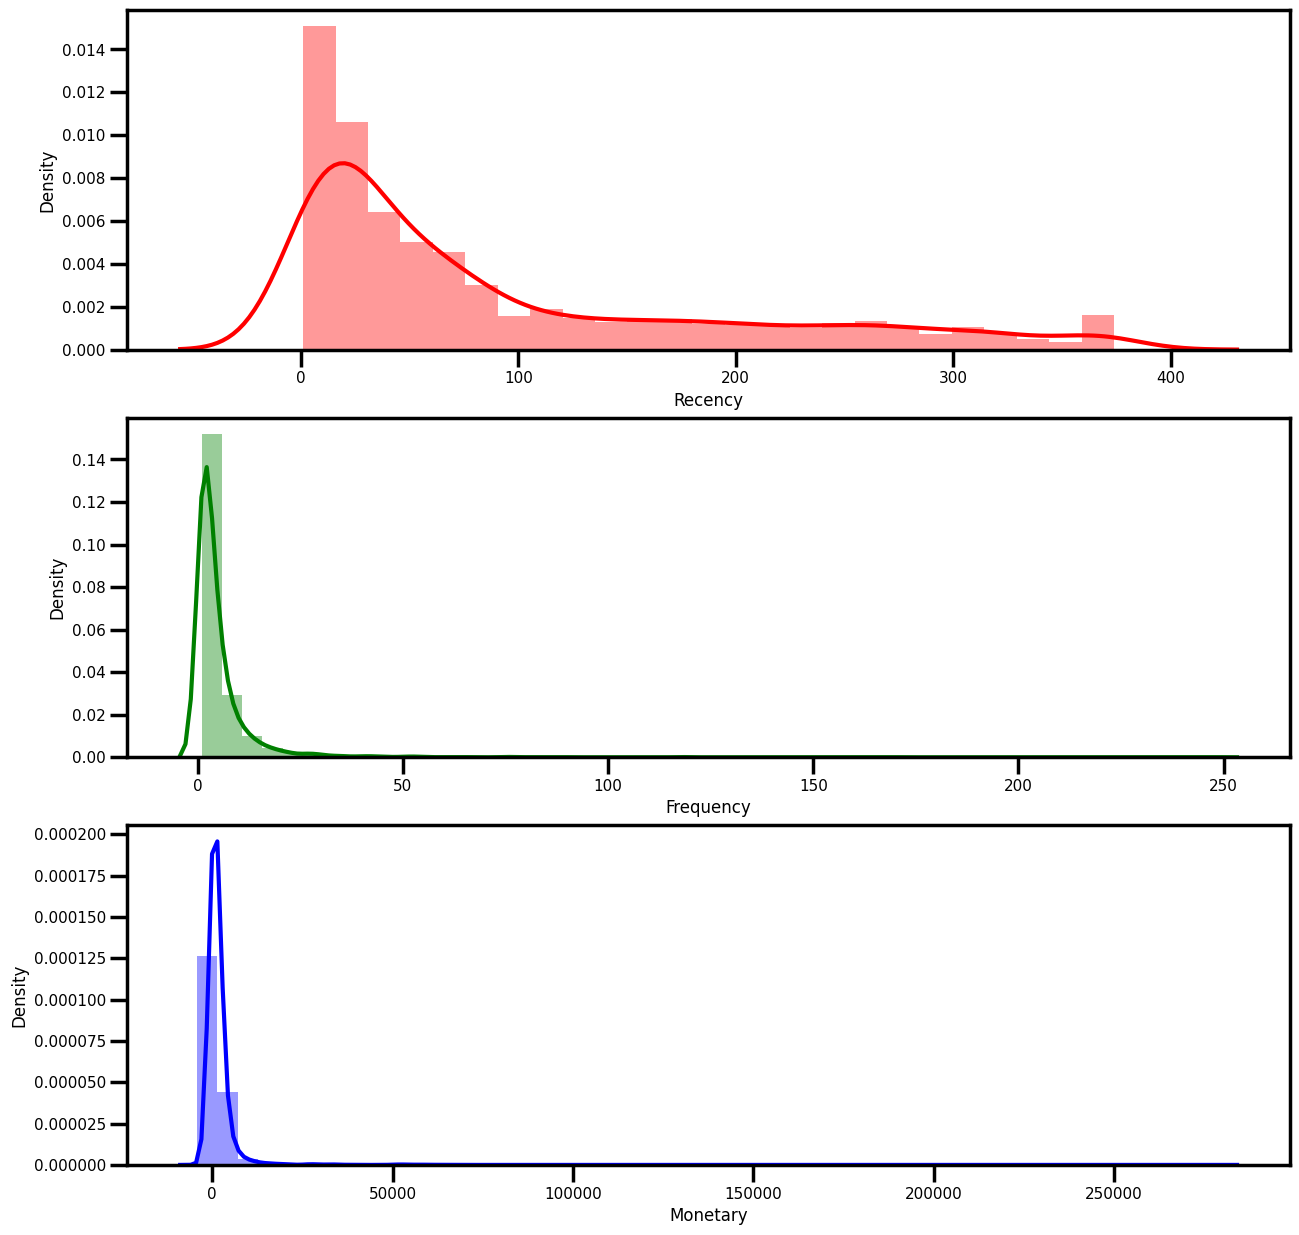

In [ ]:
fig,axes = plt.subplots(3,1,figsize=(15,15))
sns.distplot(rfm_table.Recency,color='Red',axlabel='Recency',ax=axes[0])
sns.distplot(rfm_table.Frequency,color='Green',axlabel='Frequency',ax=axes[1])
sns.distplot(rfm_table.Monetary,color='Blue',axlabel='Monetary',ax=axes[2])
plt.show()

In [ ]:
rfm_table.describe()

,Recency,Frequency,Monetary
count,4371.00,4371.00,4371.00
mean,92.60,5.08,1893.96
std,100.78,9.33,8219.59
min,1.00,1.00,-4287.63
25%,17.00,1.00,291.94
50%,51.00,3.00,644.24
75%,144.00,5.00,1608.94
max,374.00,248.00,279489.02


In [ ]:
scaled_rfm = rfm_table.copy()
scaled_rfm.Monetary = rfm_table.Monetary + abs(rfm_table.Monetary.min())+1
scaled_rfm.Recency = rfm_table.Recency + abs(rfm_table.Recency.min())+1
scaled_rfm.describe()

,Recency,Frequency,Monetary
count,4371.00,4371.00,4371.00
mean,94.60,5.08,6182.59
std,100.78,9.33,8219.59
min,3.00,1.00,1.00
25%,19.00,1.00,4580.57
50%,53.00,3.00,4932.87
75%,146.00,5.00,5897.57
max,376.00,248.00,283777.65


/tmp/ipython-input-353331224.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(normal_.Recency , color="Red", ax=axes[0], axlabel='Recency')
/tmp/ipython-input-353331224.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(normal_.Frequency , color="Green", ax=axes[1], axlabel='Frequency')
/tm

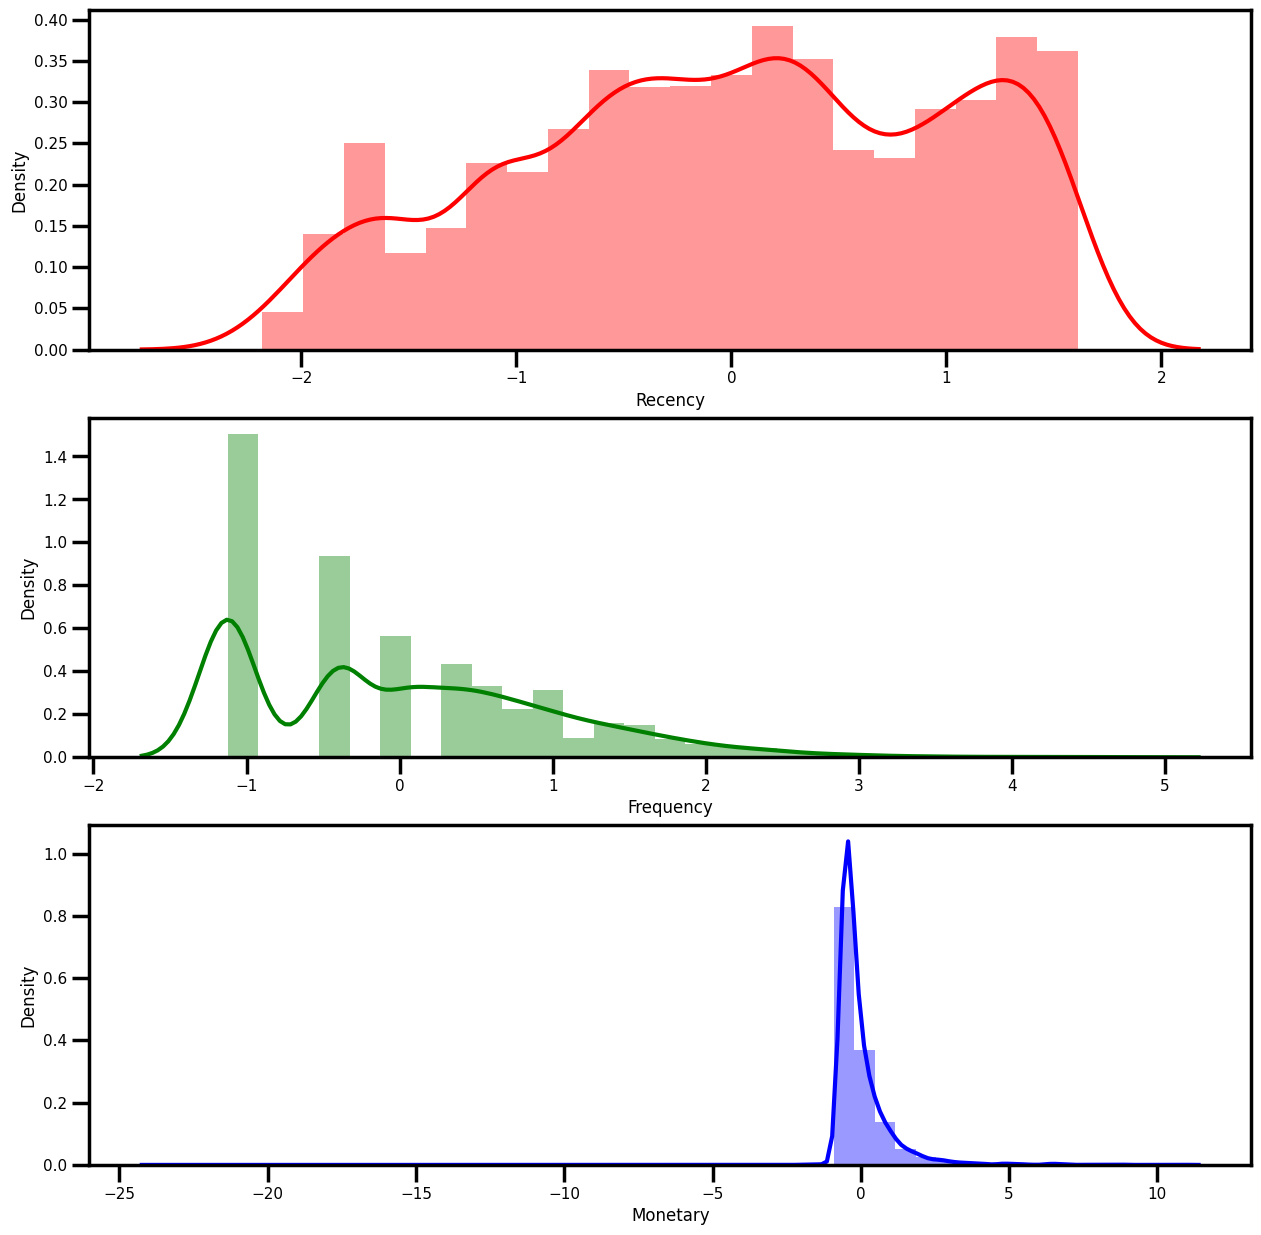

In [ ]:
from sklearn.preprocessing import StandardScaler

log_df = np.log(scaled_rfm)
scal = StandardScaler()
normal_ = scal.fit_transform(log_df)
normal_ = pd.DataFrame(data=normal_,index = rfm_table.index,columns=rfm_table.columns)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_.Recency , color="Red", ax=axes[0], axlabel='Recency')
sns.distplot(normal_.Frequency , color="Green", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_.Monetary , color="Blue", ax=axes[2], axlabel='Monetary')
plt.show()

## Silhouette Method for finding optimal K-value

Silhouette score for number of cluster(s) 2: 0.4347974450798171
Silhouette score for number of cluster(s) 3: 0.39384837911172893
Silhouette score for number of cluster(s) 4: 0.3499127612123928
Silhouette score for number of cluster(s) 5: 0.36028365201096196
Silhouette score for number of cluster(s) 6: 0.32534759629103915
Silhouette score for number of cluster(s) 7: 0.32690753827766605
Silhouette score for number of cluster(s) 8: 0.35031339977489834
Silhouette score for number of cluster(s) 9: 0.35047387016116516
Silhouette score for number of cluster(s) 10: 0.3567724111423075
Silhouette score for number of cluster(s) 11: 0.36104250907904867


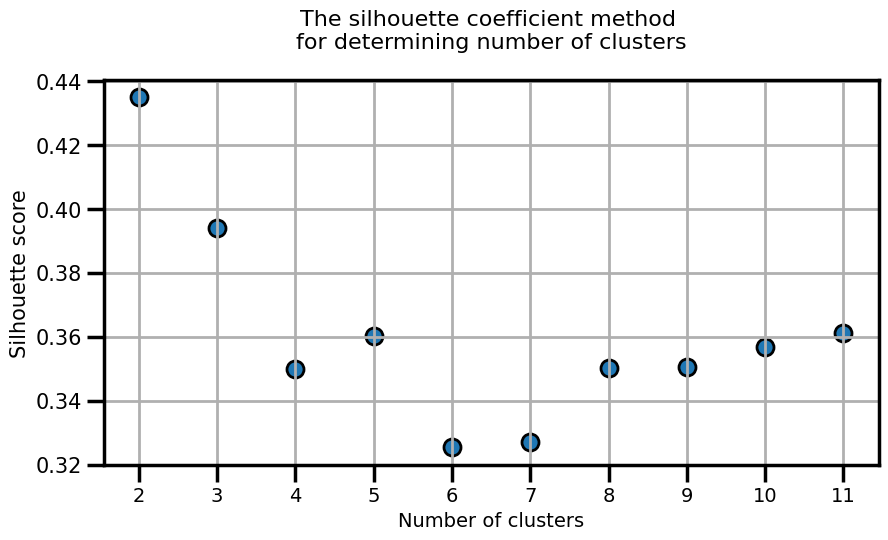

In [ ]:
 from sklearn.metrics import silhouette_score
 from sklearn.cluster import KMeans
wcss_silhouette = []
for i in range(2,12):
    kmean = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_)
    predss = kmean.predict(normal_)
    silhouette = silhouette_score(normal_,predss)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

## Optimal Value for K=4

In [ ]:
kme = KMeans(n_clusters=4, random_state=1, init='k-means++')
kme.fit(normal_)
cluster_labels = kme.labels_
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

Shape of cluster label array is (4371,)
Shape of RFM segment dataframe is (4371, 8)


,count
Cluster,
1,1811
2,1233
0,1152
3,175


In [ ]:
Cluster_table.sample(10)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
17863,60,6,3160.00,2,4,4,244,Almost Lost,0
12897,205,2,216.50,1,2,1,121,others,1
17079,79,1,118.80,2,1,1,211,others,1
14375,186,1,235.56,1,1,1,111,others,1
13358,269,1,439.03,1,1,2,112,others,1
12450,157,2,197.88,1,2,1,121,others,1
16010,246,3,392.40,1,2,2,122,Lost Cheap Customers,1
12584,4,18,1893.95,4,4,4,444,Best Customers,0
12864,139,1,147.12,2,1,1,211,others,1


In [ ]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
15856,5,31,15929.74,4,4,4,444,Best Customers,3
15159,2,34,18573.68,4,4,4,444,Best Customers,3
15311,1,118,59284.19,4,4,4,444,Best Customers,3
13113,1,40,10510.00,4,4,4,444,Best Customers,3
13599,2,33,5026.85,4,4,4,444,Best Customers,3


In [ ]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
13359,60,2,431.26,2,2,2,222,others,2
17720,27,4,1195.94,3,3,3,333,others,2
17603,51,5,-1165.30,3,3,1,331,others,2
14250,8,3,1904.05,4,2,4,424,others,2
16372,34,2,355.73,3,2,2,322,others,2


In [ ]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
13955,155,2,322.96,1,2,2,122,Lost Cheap Customers,1
16146,158,3,734.13,1,2,3,123,others,1
13260,62,1,557.62,2,1,2,212,others,1
14114,274,2,386.53,1,2,2,122,Lost Cheap Customers,1
12611,53,1,1193.32,2,1,3,213,others,1


In [ ]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

,Recency,Frequency,Monetary,Recency_Quartile,Frequency_Quartile,Monetary_Quartile,RFMPoints,Segment,Cluster
CustomerID,,,,,,,,,
13813,40,5,1353.41,3,3,3,333,others,0
16086,60,6,1119.31,2,4,3,243,others,0
17191,29,7,2093.68,3,4,4,344,Loyal Customers,0
17997,75,12,1503.09,2,4,3,243,others,0
14101,74,6,5976.79,2,4,4,244,Almost Lost,0


## Clusters in Scatter Plot

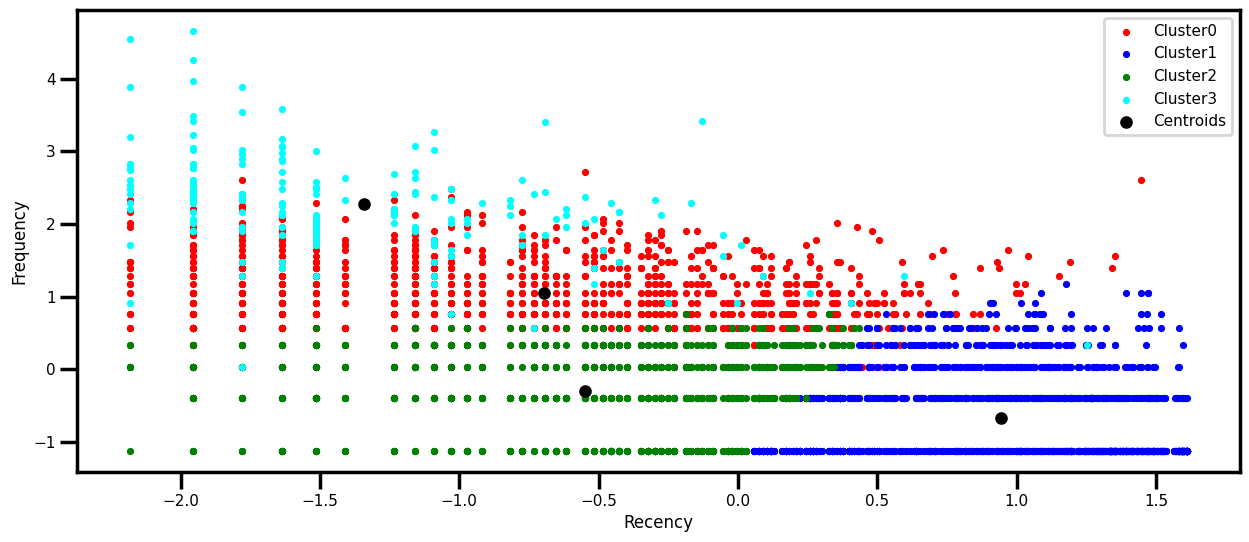

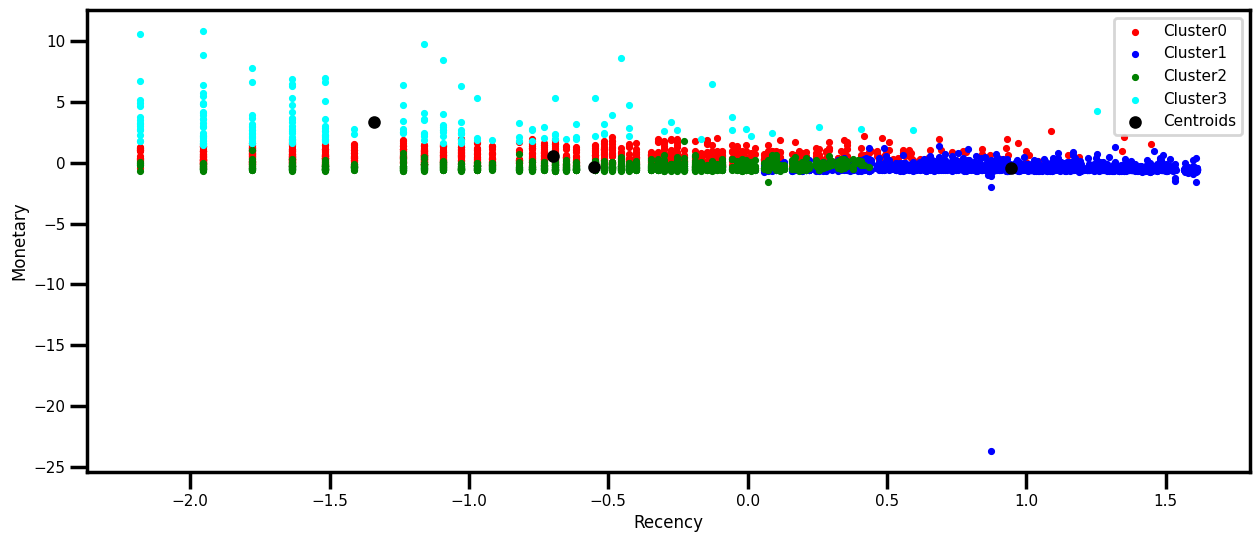

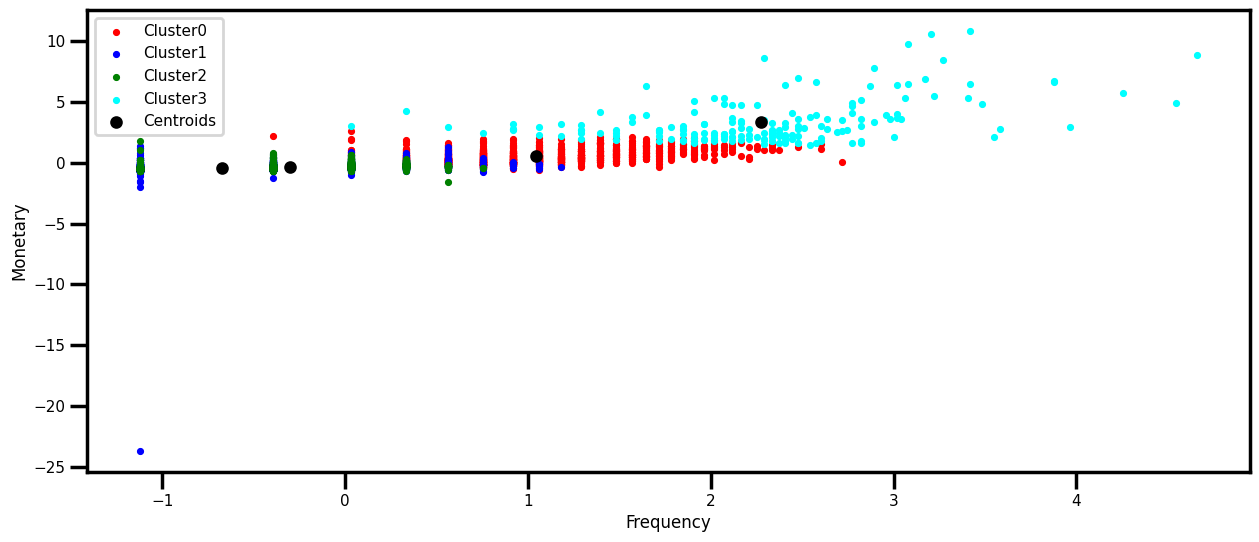

In [ ]:
# Plotting two dimesional plots of each attributes respectively.
Y = normal_.iloc[:,0:3].values
count=Y.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(Y[cluster_labels == 0, i], Y[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(Y[cluster_labels == 1, i], Y[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(Y[cluster_labels == 2, i], Y[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(Y[cluster_labels == 3, i], Y[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kme.cluster_centers_[:,i], kme.cluster_centers_[:,j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(normal_.columns[i])
        plt.ylabel(normal_.columns[j])
        plt.legend()
        plt.show();

## Snake Plot

### Melt in Pandas

In [ ]:
# Assign Cluster values to each customer in normalized dataframe
normal_ = normal_.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,1,Recency,1.50
1,12347,0,Recency,-1.78
2,12348,2,Recency,0.38
3,12349,2,Recency,-0.65
4,12350,1,Recency,1.47


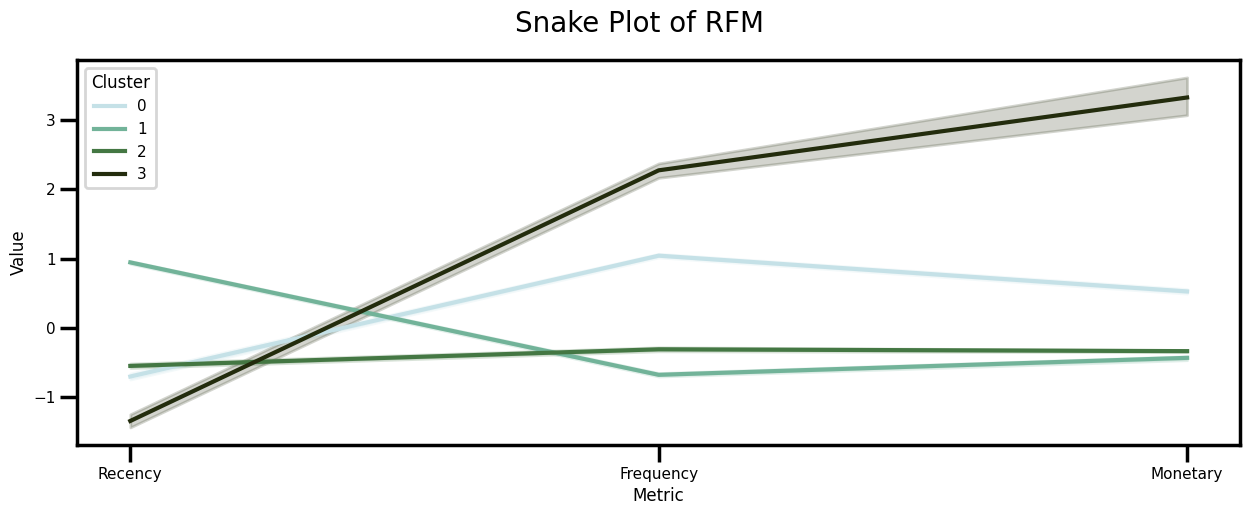

In [ ]:
plt.figure(figsize=(15,5))
palette = sns.color_palette("mako_r", 4)
sns.lineplot(x = 'Metric',y = 'Value',hue = 'Cluster',data = normal_melt,palette = "ch:4.4,.44")
plt.suptitle("Snake Plot of RFM",fontsize=20)
plt.show()

In [115]:
# Creating Final RFM Scores
rfm_segmentation['RFMScore'] = (
    rfm_segmentation.R_Quartile.map(str) +
    rfm_segmentation.F_Quartile.map(str) +
    rfm_segmentation.M_Quartile.map(str)
)

rfm_segmentation.head()


,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,326,2,0.00,1,2,1,121
12347,3,7,4310.00,4,4,4,444
12348,76,4,1797.24,2,3,4,234
12349,19,1,1757.55,3,1,4,314
12350,311,1,334.40,1,1,2,112


## Association Data Mining

### Creating Transaction Level Dataframe

In [ ]:
items = list(rfm_train.Description.unique())
grouped = rfm_train.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
# A Transaction dataframe with items as columns with binary values is created
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

Dataset Pruning for Frequently Purchased Items

In [ ]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5,
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()

    total_items = sum(input_df.sum().sort_values(ascending = False))
    #print(total_items)
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols:
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

In [ ]:
# Adding a new column denoting the total amount in a purchase

In [ ]:
rfm_train['Amount'] = rfm_train.Quantity*rfm_train.UnitPrice

In [ ]:
AmoutSum = rfm_train.groupby(["Description"]).Amount.sum().sort_values(ascending = False)
inv = rfm_train[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
 agg(np.size).sort_values(ascending = False)
Top10Ev = list(inv[:10].index)
Top15ev = list(inv[:15].index)

/tmp/ipython-input-2021587307.py:3: FutureWarning: using <function size at 0x7a6ac0c299e0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  agg(np.size).sort_values(ascending = False)


In [ ]:
# Pruning based on Rank of items

In [ ]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print(output_df)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

       WHITE HANGING HEART T-LIGHT HOLDER  REGENCY CAKESTAND 3 TIER  \
13                                      0                         0   
23                                      1                         0   
27                                      0                         0   
33                                      1                         0   
36                                      0                         0   
...                                   ...                       ...   
21809                                   1                         0   
21938                                   0                         1   
21983                                   0                         0   
21995                                   0                         1   
22069                                   0                         0   

       JUMBO BAG RED RETROSPOT  PARTY BUNTING  ASSORTED COLOUR BIRD ORNAMENT  \
13                           0              0                      

## Importing necessary libraries for association rule mining

In [ ]:
!pip install orange3

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.

In [ ]:
!pip install Orange3-Associate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.6/388.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from sklearn import preprocessing
from orangecontrib.associate.fpgrowth import *

## Creating Orange Table Data Structure

In [ ]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])


# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,
                                         X=input_assoc_rules.values,Y= None)


# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)
print(data_tran_en)
print(sorted(mapping.items()))

[[ True False  True ... False  True False]
 [False  True  True ... False  True False]
 [ True False  True ... False  True False]
 ...
 [ True False  True ... False  True False]
 [ True False False ... False  True False]
 [ True False  True ... False  True False]]
[(0, (0, 0)), (1, (0, 1)), (2, (1, 0)), (3, (1, 1)), (4, (2, 0)), (5, (2, 1)), (6, (3, 0)), (7, (3, 1)), (8, (4, 0)), (9, (4, 1)), (10, (5, 0)), (11, (5, 1)), (12, (6, 0)), (13, (6, 1)), (14, (7, 0)), (15, (7, 1)), (16, (8, 0)), (17, (8, 1)), (18, (9, 0)), (19, (9, 1)), (20, (10, 0)), (21, (10, 1)), (22, (11, 0)), (23, (11, 1)), (24, (12, 0)), (25, (12, 1)), (26, (13, 0)), (27, (13, 1)), (28, (14, 0)), (29, (14, 1))]


In [ ]:
support = 0.01
# Number of minimum transactions for each rule
print("Number  of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

Number  of required transactions =  47
Items Set Size: 661418


## Generating Rules using FP_Growth_Algorithm

In [ ]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000:
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    print(names)

    eligible_ante = [v for k,v in names.items() if v.endswith("1")]

    N = input_assoc_rules.shape[0]

    rule_stats = list(rules_stats(rules, itemsets, N))

    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]
        cons = ex_rule_frm_rule_stat[1]

        named_cons = names[next(iter(cons))]

        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)

    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if  rules_df.empty:
        print("No rule generated")
    pd.options.display.max_colwidth = 10
    print(rules_df.head())

{0: 'WHITE HANGING HEART T-LIGHT HOLDER=0', 1: 'WHITE HANGING HEART T-LIGHT HOLDER=1', 2: 'REGENCY CAKESTAND 3 TIER=0', 3: 'REGENCY CAKESTAND 3 TIER=1', 4: 'JUMBO BAG RED RETROSPOT=0', 5: 'JUMBO BAG RED RETROSPOT=1', 6: 'PARTY BUNTING=0', 7: 'PARTY BUNTING=1', 8: 'ASSORTED COLOUR BIRD ORNAMENT=0', 9: 'ASSORTED COLOUR BIRD ORNAMENT=1', 10: 'LUNCH BAG RED RETROSPOT=0', 11: 'LUNCH BAG RED RETROSPOT=1', 12: 'SET OF 3 CAKE TINS PANTRY DESIGN =0', 13: 'SET OF 3 CAKE TINS PANTRY DESIGN =1', 14: 'POSTAGE=0', 15: 'POSTAGE=1', 16: 'LUNCH BAG  BLACK SKULL.=0', 17: 'LUNCH BAG  BLACK SKULL.=1', 18: 'PACK OF 72 RETROSPOT CAKE CASES=0', 19: 'PACK OF 72 RETROSPOT CAKE CASES=1', 20: 'SPOTTY BUNTING=0', 21: 'SPOTTY BUNTING=1', 22: 'LUNCH BAG SPACEBOY DESIGN =0', 23: 'LUNCH BAG SPACEBOY DESIGN =1', 24: "PAPER CHAIN KIT 50'S CHRISTMAS =0", 25: "PAPER CHAIN KIT 50'S CHRISTMAS =1", 26: 'LUNCH BAG CARS BLUE=0', 27: 'LUNCH BAG CARS BLUE=1', 28: 'NATURAL SLATE HEART CHALKBOARD =0', 29: 'NATURAL SLATE HEART CHA

## First 5 rules with highest confidence

In [ ]:
#Storing the value of default column width in a temporary variable default_width
default_width = pd.options.display.max_colwidth

pd.options.display.max_colwidth = 50


print((rules_df[['consequent','antecedent', 'support','confidence','lift']].
 sort_values(['confidence','support','lift'],ascending=False)))

                    consequent  \
2210   LUNCH BAG RED RETROSPOT   
4621   LUNCH BAG RED RETROSPOT   
4943   LUNCH BAG RED RETROSPOT   
4659   LUNCH BAG RED RETROSPOT   
7632   LUNCH BAG RED RETROSPOT   
...                        ...   
12658  LUNCH BAG RED RETROSPOT   
12685  LUNCH BAG RED RETROSPOT   
13113  LUNCH BAG RED RETROSPOT   
13175  LUNCH BAG RED RETROSPOT   
13246  LUNCH BAG RED RETROSPOT   

                                              antecedent  support  confidence  \
2210   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       54        0.82   
4621   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       54        0.82   
4943   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       57        0.81   
4659   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       61        0.81   
7632   JUMBO BAG RED RETROSPOT, LUNCH BAG  BLACK SKUL...       61        0.81   
...                                                  ...      ...         ...   
12658  JUMBO BAG RED RET

## First 5 rules with highest support

In [ ]:
pd.options.display.max_colwidth = 10

print((rules_df[['consequent', 'antecedent', 'support','confidence','lift']].
 groupby(['consequent', 'antecedent']).first().reset_index().sort_values(['support', 'confidence', 'lift'],ascending=False)).head())

   consequent antecedent  support  confidence  lift
36  LUNCH ...  LUNCH ...      200       0.61   2.41
37  LUNCH ...  LUNCH ...      198       0.60   2.38
39  LUNCH ...  LUNCH ...      153       0.60   2.39
25  LUNCH ...  LUNCH ...      137       0.66   2.62
31  LUNCH ...  LUNCH ...      134       0.61   2.40


In [ ]:
print(rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts())


lift
Greater Than One    13275
Name: count, dtype: int64


In [ ]:
pd.options.display.max_colwidth = default_width

## Recommendation

In [ ]:
print(" Please choose an Item : ")
print(" Available Items :" )
available_items = rules_df['consequent'].unique()
available_items = pd.DataFrame(available_items)
print(available_items)
chosen_item = input()
recommend_items_df = rules_df.loc[rules_df['consequent']==chosen_item]['antecedent']

print(" Products related to your chosen item . Consider purchasing the following products : ")
print(recommend_items_df.head(10).unique())

 Please choose an Item : 
 Available Items :
           0
0  LUNCH ...
1  LUNCH ...
2  LUNCH ...
3  LUNCH ...
lunch
 Products related to your chosen item . Consider purchasing the following products : 
[]
